In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


In [5]:
print(tf.config.list_physical_devices())
print(np.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1.23.3


In [6]:
print(tf.__version__)

2.15.0


In [7]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data,dtype="object")

In [8]:
train = get_training_data('/content/drive/MyDrive/pneumonia_data/train_CLAHE')
test = get_training_data('/content/drive/MyDrive/pneumonia_data/test_CLAHE')
val = get_training_data('/content/drive/MyDrive/pneumonia_data/val_CLAHE')

<Axes: xlabel='count'>

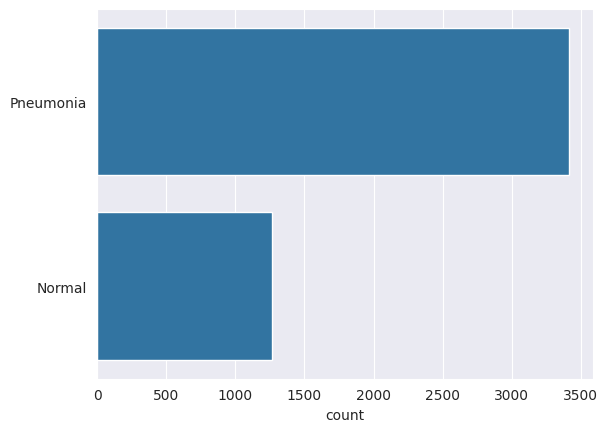

In [9]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

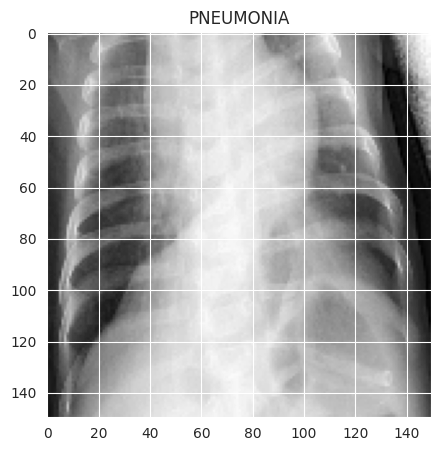

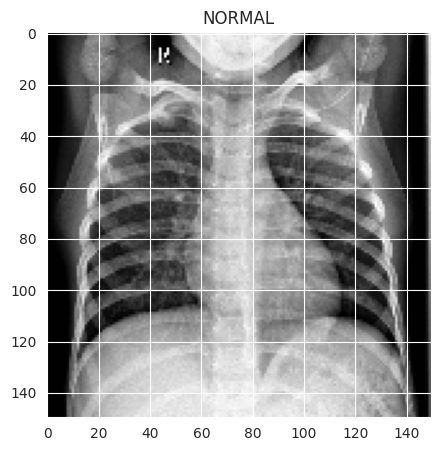

In [10]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [11]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [12]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [13]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

print("Count before augmentation:", len(x_train))

Count before augmentation: 4684


In [14]:
print(np.__version__)

1.23.3


In [15]:
# pip install numpy==1.23.3

In [16]:
def load_augmented_data(augmented_dir, label, img_size):
    augmented_data = []
    for img in os.listdir(augmented_dir):
        try:
            img_arr = cv2.imread(os.path.join(augmented_dir, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            augmented_data.append([resized_arr, label])
        except Exception as e:
            print(e)
    return np.array(augmented_data)

# Define parameters
save_dir = '/content/drive/MyDrive/pneumonia_data/augmented_CLAHE/NORMAL'  # Directory to save augmented images
label = 'NORMAL'  # Class label to augment
img_size = 150  # Image size (adjust if different)
additional_images_needed = 2690  # Number of additional images needed
batch_size = 32  # Number of images to generate per original image

# Load augmented 'Normal' images (assuming label for 'Normal' is 1)
augmented_normal_data = load_augmented_data(save_dir, label=1, img_size=img_size)

# Convert to appropriate format and normalize
x_augmented_normal = np.array([i[0] for i in augmented_normal_data]) / 255
x_augmented_normal = x_augmented_normal.reshape(-1, img_size, img_size, 1)
y_augmented_normal = np.array([i[1] for i in augmented_normal_data])

# Append to existing training data
x_train = np.concatenate((x_train, x_augmented_normal), axis=0)
y_train = np.concatenate((y_train, y_augmented_normal), axis=0)

# Shuffle the dataset
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# Count after augmentation
print("Count after augmentation:", len(x_train))



<ipython-input-16-58426f56cd15>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(augmented_data)


Count after augmentation: 7069


# Optimization

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

class CNN(Sequential):
    def __init__(self, nfilters, sfilters):
        super().__init__()
        tf.random.set_seed(0)
        self.add(Conv2D(nfilters[0], kernel_size=(sfilters[0], sfilters[0]), padding='same', activation='relu', input_shape=(150, 150, 1)))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        self.add(Conv2D(nfilters[1], kernel_size=(sfilters[1], sfilters[1]), padding='same', activation='relu'))
        self.add(Dropout(0.1))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        self.add(Conv2D(nfilters[2], kernel_size=(sfilters[2], sfilters[2]), padding='same', activation='relu'))
        self.add(Dropout(0.2))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        self.add(Flatten())
        self.add(Dropout(0.2))
        self.add(Dense(128, activation='relu'))
        self.add(Dense(units=1, activation='sigmoid'))
        self.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
class Genetic:
    def __init__(self, pop_size, nlayers, max_nfilters, max_sfilters):
        self.pop_size = pop_size
        self.nlayers = nlayers
        self.max_nfilters = max_nfilters
        self.max_sfilters = max_sfilters
        self.max_acc = 0
        self.best_arch = np.zeros((1, 6))
        self.gen_acc = []


    # def generate_population(self):
    #     np.random.seed(0)

    #     # Membuat partisi untuk nfilter
    #     partition_size_nfilter = self.max_nfilters // self.pop_size
    #     pop_nlayers = np.array([
    #         np.random.randint(1 + i * partition_size_nfilter, (i + 1) * partition_size_nfilter, self.nlayers)
    #         for i in range(self.pop_size)
    #     ])

    #     # Membuat partisi untuk sfilter
    #     partition_size_sfilter = self.max_sfilters // self.pop_size
    #     pop_sfilters = np.array([
    #         np.random.randint(1 + i * partition_size_sfilter, (i + 1) * partition_size_sfilter, self.nlayers)
    #         for i in range(self.pop_size)
    #     ])

    #     # Menggabungkan kedua set parameter
    #     pop_total = np.concatenate((pop_nlayers, pop_sfilters), axis=1)
    #     return pop_total

    def generate_unique_values(self, max_value, taken_values):
        partition_size = max_value // self.nlayers
        unique_values = []
        for j in range(self.nlayers):
            start = j * partition_size + 1
            if j == self.nlayers - 1:  # Ensure the last partition reaches the max value
                end = max_value + 1
            else:
                end = start + partition_size

            # Generate a unique value within the partition
            value = np.random.randint(start, end)
            while value in taken_values:  # Ensure uniqueness
                value += 1
                if value >= end:  # Reset if exceeds partition
                    value = start

            taken_values.add(value)
            unique_values.append(value)

        return unique_values

    def generate_population(self):
        np.random.seed(0)

        # Initialize population array
        pop_total = np.zeros((self.pop_size, self.nlayers * 2), dtype=int)

        for i in range(self.pop_size):
            taken_values_nfilters = set()
            taken_values_sfilters = set()

            # Generate unique nfilters and sfilters for each individual
            nfilters = self.generate_unique_values(self.max_nfilters, taken_values_nfilters)
            sfilters = self.generate_unique_values(self.max_sfilters, taken_values_sfilters)

            # Combine nfilters and sfilters for the individual
            pop_total[i] = nfilters + sfilters

        return pop_total


    def select_parents(self, pop, nparents, fitness):
        parents = np.zeros((nparents, pop.shape[1]))
        for i in range(nparents):
            best = np.argmax(fitness)
            parents[i] = pop[best]
            fitness[best] = -99999
        return parents

    def crossover(self, parents):
        nchild = self.pop_size - parents.shape[0]
        nparents = parents.shape[0]
        child = np.zeros((nchild, parents.shape[1]))
        for i in range(nchild):
            first = i % nparents
            second = (i + 1) % nparents
            child[i, :2] = parents[first][:2]
            child[i, 2] = parents[second][2]
            child[i, 3:5] = parents[first][3:5]
            child[i, 5] = parents[second][5]
        return child

    def mutation(self, child):
        for i in range(child.shape[0]):
            val = np.random.randint(1, 6)
            ind = np.random.randint(1, 4) - 1
            if child[i][ind] + val > 100:
                child[i][ind] -= val
            else:
                child[i][ind] += val
            val = np.random.randint(1, 4)
            ind = np.random.randint(4, 7) - 1
            if child[i][ind] + val > 20:
                child[i][ind] -= val
            else:
                child[i][ind] += val
        return child

    def fitness(self, pop, X, Y, epochs):
        pop_acc = []
        for i in range(pop.shape[0]):
            nfilters = pop[i][0:3]
            sfilters = pop[i][3:]
            model = CNN(nfilters, sfilters)
            learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
            history = model.fit(X, Y, batch_size=64, epochs=epochs, validation_data=[x_val, y_val], callbacks=[learning_rate_reduction])
            acc = max(history.history['accuracy'])
            pop_acc.append(acc * 100)
        if max(pop_acc) > self.max_acc:
            self.max_acc = max(pop_acc)
            self.best_arch = pop[np.argmax(pop_acc)]
        self.gen_acc.append(max(pop_acc))
        return pop_acc

    def smooth_curve(self, factor, gen):
        smoothed_points = []
        for point in self.gen_acc:
            if smoothed_points:
                prev = smoothed_points[-1]
                smoothed_points.append(prev * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        plt.plot(range(gen + 1), smoothed_points, 'g', label='Smoothed training acc')
        plt.xticks(np.arange(gen + 1))
        plt.legend()
        plt.title('Fitness Accuracy vs Generations')
        plt.xlabel('Generations')
        plt.ylabel('Fitness (%)')
        plt.show()

In [37]:
pop_size = 10
nlayers = 3
max_nfilters = 100
max_sfilters = 10
epochs = 10
num_generations = 20

genCNN = Genetic(pop_size, nlayers, max_nfilters, max_sfilters)
# pop = genCNN.generate_population()
pop = np.array([[46, 59, 83,  4,  9, 20],
       [41, 61, 85,  6,  9, 19],
       [49, 60, 99, 11,  9, 15],
       [44, 60, 83,  8,  9, 18],
       [38, 65, 83,  5,  9, 20],
       [46, 61, 85,  7,  9, 19],
       [41, 66, 99,  6, 12, 15],
       [54, 60, 83, 11, 12, 18],
       [44, 65, 83, 11,  9, 20],
       [40, 65, 83,  5, 12, 20]])


# pop = np.array(result_pop)

pop

array([[46, 59, 83,  4,  9, 20],
       [41, 61, 85,  6,  9, 19],
       [49, 60, 99, 11,  9, 15],
       [44, 60, 83,  8,  9, 18],
       [38, 65, 83,  5,  9, 20],
       [46, 61, 85,  7,  9, 19],
       [41, 66, 99,  6, 12, 15],
       [54, 60, 83, 11, 12, 18],
       [44, 65, 83, 11,  9, 20],
       [40, 65, 83,  5, 12, 20]])

In [38]:
with tf.device('/cpu:0'):
   x = tf.convert_to_tensor(x_train, np.float32)
   y = tf.convert_to_tensor(y_train, np.float32)

bestModelEachGeneration = []

for i in range(num_generations + 1):
    print(pop)
    pop_acc = genCNN.fitness(pop, x, y, epochs)
    print('Best Accuracy at the generation {}: {}'.format(i, genCNN.max_acc))
    parents = genCNN.select_parents(pop, 5, pop_acc.copy())
    child = genCNN.crossover(parents)
    child = genCNN.mutation(child)
    pop = np.concatenate((parents, child), axis=0).astype('int')
    bestModelEachGeneration.append(genCNN.best_arch)


[[46 59 83  4  9 20]
 [41 61 85  6  9 19]
 [49 60 99 11  9 15]
 [44 60 83  8  9 18]
 [38 65 83  5  9 20]
 [46 61 85  7  9 19]
 [41 66 99  6 12 15]
 [54 60 83 11 12 18]
 [44 65 83 11  9 20]
 [40 65 83  5 12 20]]
Epoch 1/10
111/111 [==============================] - 4s 25ms/step - loss: 0.5732 - accuracy: 0.7660 - val_loss: 0.2306 - val_accuracy: 0.9162 - lr: 0.0010
Epoch 2/10
111/111 [==============================] - 3s 23ms/step - loss: 0.1758 - accuracy: 0.9312 - val_loss: 0.2178 - val_accuracy: 0.9162 - lr: 0.0010
Epoch 3/10
111/111 [==============================] - 3s 23ms/step - loss: 0.1178 - accuracy: 0.9560 - val_loss: 0.1073 - val_accuracy: 0.9624 - lr: 0.0010
Epoch 4/10
111/111 [==============================] - 3s 23ms/step - loss: 0.1168 - accuracy: 0.9563 - val_loss: 0.1245 - val_accuracy: 0.9487 - lr: 0.0010
Epoch 5/10
111/111 [==============================] - 2s 22ms/step - loss: 0.0858 - accuracy: 0.9702 - val_loss: 0.0843 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 6/1

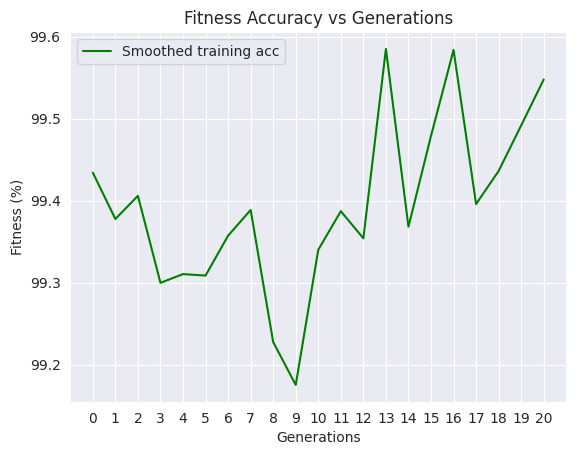

In [39]:
genCNN.smooth_curve(0.5,num_generations)

In [40]:
genCNN.best_arch

array([ 43,  73, 100,  14,  17,  19])

In [41]:
genCNN.max_acc

99.81609582901001

In [42]:
genCNN.gen_acc

[99.4341492652893,
 99.32097792625427,
 99.4341492652893,
 99.19366240501404,
 99.32097792625427,
 99.30683374404907,
 99.40585494041443,
 99.4200050830841,
 99.0663468837738,
 99.12292957305908,
 99.50488209724426,
 99.4341492652893,
 99.32097792625427,
 99.81609582901001,
 99.15122389793396,
 99.58975911140442,
 99.68878030776978,
 99.20780658721924,
 99.47658777236938,
 99.54732060432434,
 99.60390329360962]

In [43]:
bestModelEachGeneration

[array([44, 65, 83, 11,  9, 20]),
 array([44, 65, 83, 11,  9, 20]),
 array([44, 65, 83, 11,  9, 20]),
 array([44, 65, 83, 11,  9, 20]),
 array([44, 65, 83, 11,  9, 20]),
 array([44, 65, 83, 11,  9, 20]),
 array([44, 65, 83, 11,  9, 20]),
 array([44, 65, 83, 11,  9, 20]),
 array([44, 65, 83, 11,  9, 20]),
 array([44, 65, 83, 11,  9, 20]),
 array([41, 66, 97,  7, 10, 19]),
 array([41, 66, 97,  7, 10, 19]),
 array([41, 66, 97,  7, 10, 19]),
 array([ 43,  73, 100,  14,  17,  19]),
 array([ 43,  73, 100,  14,  17,  19]),
 array([ 43,  73, 100,  14,  17,  19]),
 array([ 43,  73, 100,  14,  17,  19]),
 array([ 43,  73, 100,  14,  17,  19]),
 array([ 43,  73, 100,  14,  17,  19]),
 array([ 43,  73, 100,  14,  17,  19]),
 array([ 43,  73, 100,  14,  17,  19])]

In [44]:
# Next pop
# for gen 11
# array([[38, 47, 79,  4,  5, 13],
#        [37, 47, 77,  4,  4, 11],
#        [32, 52, 79,  4,  4, 12],
#        [32, 47, 78,  4,  4,  6],
#        [40, 51, 77,  5,  9, 11],
#        [40, 47, 77,  4,  5, 13],
#        [37, 47, 81,  7,  4, 12],
#        [32, 52, 83,  4,  4,  7],
#        [32, 47, 79,  7,  4, 11],
#        [40, 51, 82,  5,  9, 14]])

# for gen 21
pop

array([[43, 74, 87, 12, 20, 16],
       [43, 77, 96, 14, 20, 16],
       [43, 78, 98, 13, 19, 19],
       [48, 74, 96, 12, 19, 19],
       [43, 78, 91, 13, 20, 16],
       [43, 77, 96, 12, 20, 19],
       [46, 77, 98, 15, 20, 19],
       [43, 78, 99, 15, 19, 19],
       [48, 74, 95, 12, 17, 16],
       [43, 79, 87, 15, 20, 16]])

# Optimized Model

In [45]:
bestParam = genCNN.best_arch
# bestParam = [35, 64, 98,  7,  8, 17]
# array([38, 47, 79,  4,  5, 13]) Gen 1 ~ 10
# array([35, 64, 98,  7,  8, 17]) Gen 21 ~ 30
bestParam

array([ 43,  73, 100,  14,  17,  19])

In [46]:
model = Sequential()
model.add(Conv2D(bestParam[0] , (bestParam[3],bestParam[3]) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(bestParam[1] , (bestParam[4],bestParam[4]) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(bestParam[2] , (bestParam[5],bestParam[5]) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_963 (Conv2D)         (None, 150, 150, 43)      8471      
                                                                 
 max_pooling2d_963 (MaxPool  (None, 75, 75, 43)        0         
 ing2D)                                                          
                                                                 
 conv2d_964 (Conv2D)         (None, 75, 75, 73)        907244    
                                                                 
 dropout_963 (Dropout)       (None, 75, 75, 73)        0         
                                                                 
 max_pooling2d_964 (MaxPool  (None, 38, 38, 73)        0         
 ing2D)                                                          
                                                                 
 conv2d_965 (Conv2D)         (None, 38, 38, 100)      

In [47]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [48]:
history = model.fit(x_train,y_train, batch_size = 64 ,epochs = 10 , validation_data = [x_val, y_val] ,callbacks = [learning_rate_reduction])

Epoch 1/10
111/111 [==============================] - 15s 61ms/step - loss: 1.0784 - accuracy: 0.5493 - val_loss: 0.6304 - val_accuracy: 0.6906 - lr: 0.0010
Epoch 2/10
111/111 [==============================] - 4s 34ms/step - loss: 0.3788 - accuracy: 0.8307 - val_loss: 0.2241 - val_accuracy: 0.9265 - lr: 0.0010
Epoch 3/10
111/111 [==============================] - 4s 34ms/step - loss: 0.1684 - accuracy: 0.9361 - val_loss: 0.1226 - val_accuracy: 0.9607 - lr: 0.0010
Epoch 4/10
111/111 [==============================] - 4s 34ms/step - loss: 0.1226 - accuracy: 0.9567 - val_loss: 0.1060 - val_accuracy: 0.9590 - lr: 0.0010
Epoch 5/10
111/111 [==============================] - 4s 34ms/step - loss: 0.0869 - accuracy: 0.9690 - val_loss: 0.0973 - val_accuracy: 0.9624 - lr: 0.0010
Epoch 6/10
111/111 [==============================] - 4s 34ms/step - loss: 0.1048 - accuracy: 0.9604 - val_loss: 0.0986 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 7/10
111/111 [==============================] - 4s 34ms/s

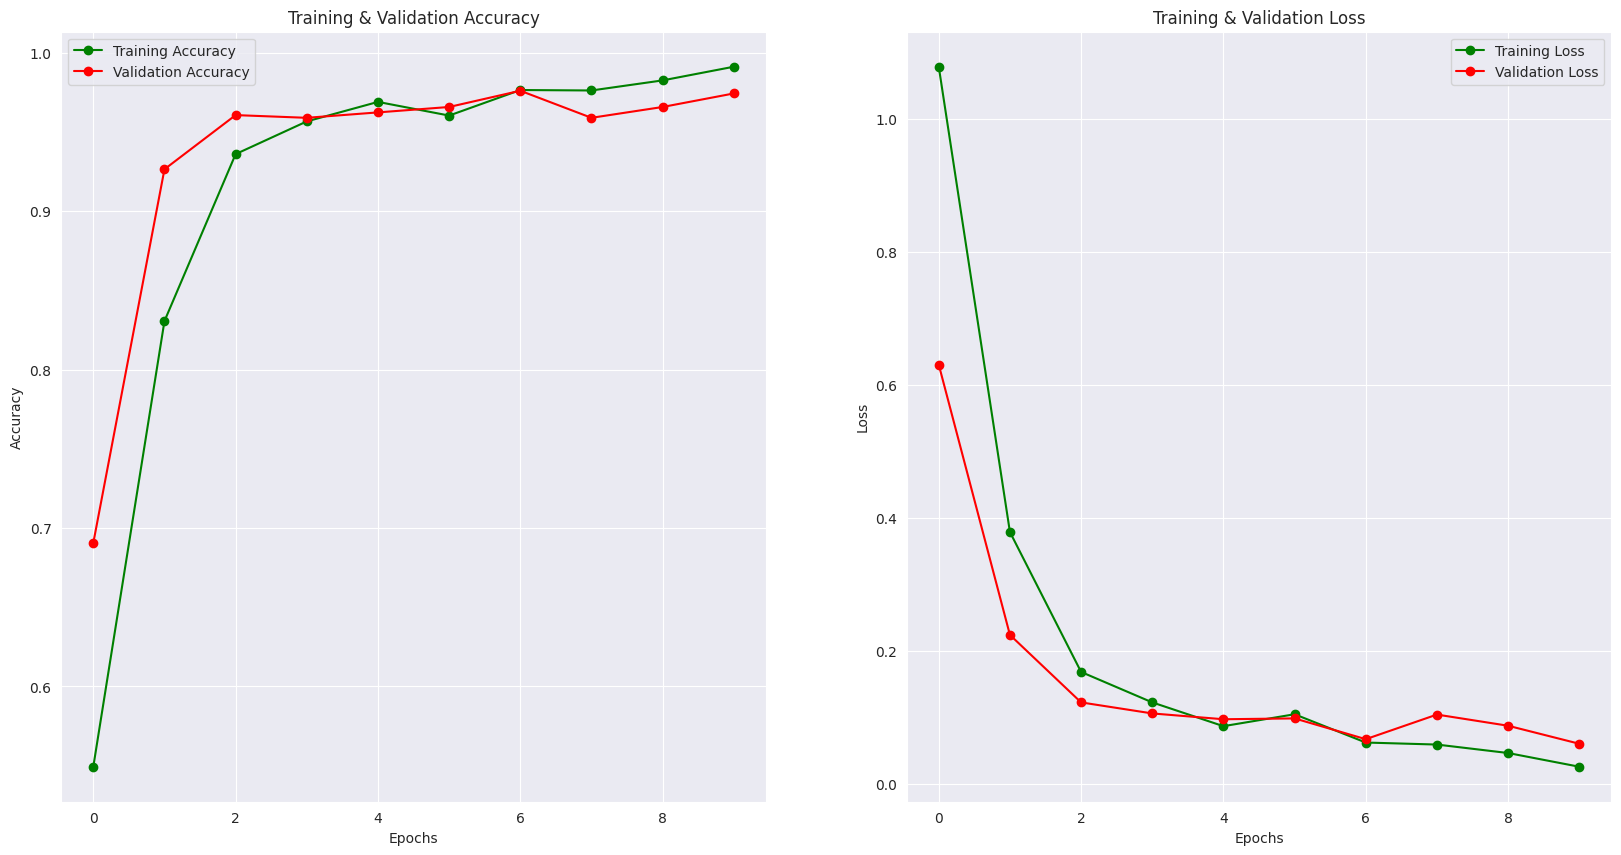

In [49]:
# Adjust the range to match the number of epochs in your history data
epochs = [i for i in range(len(history.history['accuracy']))]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


In [50]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

19/19 [==============================] - 1s 22ms/step


array([2.4960155e-02, 9.8592803e-02, 3.9716752e-04, 2.6626783e-04,
       1.6177364e-05, 2.4571086e-01, 4.7344274e-05, 2.9017390e-03,
       1.0227851e-06, 5.8478548e-08, 5.9566484e-03, 1.3586500e-08,
       5.8917791e-01, 1.1239053e-05, 6.9331031e-06], dtype=float32)

In [51]:
from sklearn.metrics import classification_report

# Assuming predictions are probabilities, convert them to binary labels
binary_predictions = [1 if i > 0.5 else 0 for i in predictions]

# Generate a classification report
print(classification_report(y_test, binary_predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.99      0.98      0.98       428
   Normal (Class 1)       0.95      0.97      0.96       159

           accuracy                           0.98       587
          macro avg       0.97      0.97      0.97       587
       weighted avg       0.98      0.98      0.98       587



In [52]:
cm = confusion_matrix(y_test,binary_predictions)
cm

array([[420,   8],
       [  5, 154]])

In [53]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

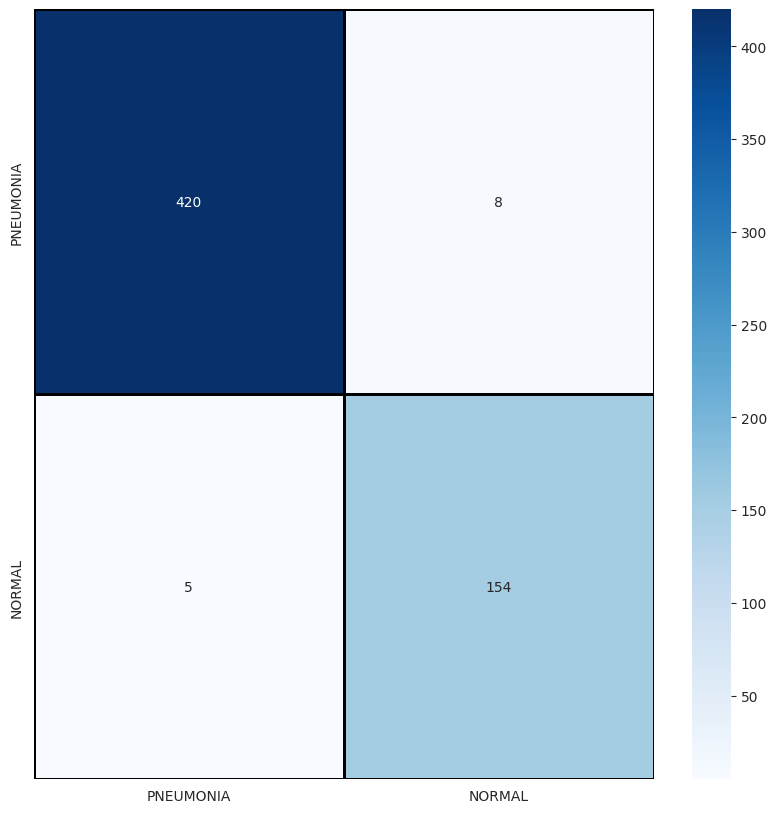

In [54]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)